# ÁP DỤNG MÔ HÌNH VỚI NEW DATA
Áp dụng các mô hình ANN và SVM đã huấn luyện để dự đoán giao dịch bất thường trên tập new data.


#### Khai báo thư viện

In [1]:
# Import các thư viện cần thiết
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from keras.src.saving import load_model

2024-12-04 07:22:47.297019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nguyendinhkhai/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Khai báo đường dẫn

In [11]:
# Đường dẫn dữ liệu và mô hình
processed_data_path = "../data/new_data/processed/new_data_processed.csv"
ann_model_path = "../models/ann_model.keras"
svm_model_path = "../models/svm_model.pkl"
output_file_path = "../data/new_data/predict"
os.makedirs(output_file_path, exist_ok=True)
plot_dir = "../plots/predictions"
os.makedirs(plot_dir, exist_ok=True)

###  Tải dữ liệu
Dữ liệu được tải từ `new_data_processed.csv`.


In [3]:
# Tải dữ liệu đã xử lý
new_data = pd.read_csv(processed_data_path)
print("Dữ liệu đã xử lý:")
print(new_data.head())

# Đảm bảo cột `Timestamp` là datetime
new_data["Timestamp"] = pd.to_datetime(new_data["Timestamp"])


Dữ liệu đã xử lý:
             Timestamp      Open      High       Low     Close    Volume  \
0  2023-04-02 04:00:00 -0.117977 -0.117984 -0.117970 -0.117977 -0.131704   
1  2023-04-02 12:00:00 -0.117977 -0.117984 -0.117970 -0.117977 -0.130475   
2  2023-04-03 01:00:00 -0.117977 -0.117984 -0.117971 -0.117977 -0.131646   
3  2023-04-03 03:00:00 -0.117977 -0.117984 -0.117971 -0.117977 -0.131697   
4  2023-04-03 05:00:00 -0.117977 -0.117984 -0.117971 -0.117977 -0.131699   

      Pair  Exchange  Price_Change_Pct  Volume_Spike  Volatility  
0  CLV-GBP  Coinbase          -0.00200     -0.788665   -0.100952  
1  CLV-GBP  Coinbase          -0.15265     -0.374128   -0.100949  
2  CLV-GBP  Coinbase          -0.00200     -0.779682   -0.100952  
3  CLV-GBP  Coinbase          -0.00200     -0.792254   -0.100952  
4  CLV-GBP  Coinbase          -0.00200     -0.793852   -0.100947  


### Tải mô hình
Mô hình ANN và SVM được tải từ thư mục `models`.


In [4]:
# Tải mô hình ANN đã huấn luyện
ann_model = load_model(ann_model_path)

# Chọn các cột đặc trưng
features = ["Open", "High", "Low", "Close", "Volume", "Price_Change_Pct", "Volume_Spike", "Volatility"]

# Trích xuất đặc trưng từ ANN
new_data_features = ann_model.predict(new_data[features])
print(f"Kích thước đặc trưng từ ANN: {new_data_features.shape}")

# Tải mô hình SVM đã huấn luyện
svm_model = joblib.load(svm_model_path)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Kích thước đặc trưng từ ANN: (7997, 1)


### Dự đoán nhãn
ANN trích xuất đặc trưng.  
SVM dự đoán nhãn (0 hoặc 1).


In [5]:
# Dự đoán nhãn cho dữ liệu mới
# Ngưỡng dự đoán
threshold = 0.7
new_data["Predicted_Label"] = (svm_model.predict_proba(new_data_features)[:, 1] > threshold).astype(int)


# Hiển thị phân phối nhãn
print("Phân phối nhãn dự đoán:")
print(new_data["Predicted_Label"].value_counts())


Phân phối nhãn dự đoán:
Predicted_Label
0    7799
1     198
Name: count, dtype: int64


### Lưu kết quả
Kết quả dự đoán được lưu vào file `new_data_redictions.csv`.


In [6]:
# Lưu kết quả dự đoán
new_data_sorted = new_data.sort_values(by="Timestamp")
new_data_sorted.to_csv(f"{output_file_path}/new_data_predictions.csv", index=False)
print(f"Kết quả đã được lưu tại: {output_file_path}")


Kết quả đã được lưu tại: ../data/new_data/predict


### Trực quan hóa
Phân tích số lượng giao dịch gian lận được phát hiện.  
Trực quan hóa các đặc trưng quan trọng.

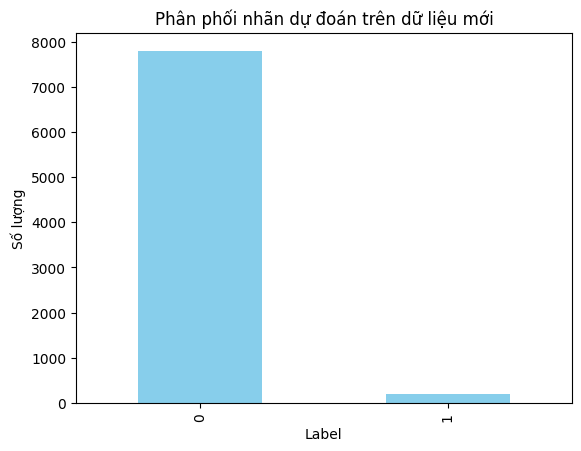

In [13]:
# Vẽ biểu đồ phân phối nhãn
new_data["Predicted_Label"].value_counts().plot(kind="bar", color="skyblue")
plt.title("Phân phối nhãn dự đoán trên dữ liệu mới")
plt.xlabel("Label")
plt.ylabel("Số lượng")
plt.savefig(os.path.join(plot_dir, "fraud_vs_non_fraud.png"))
plt.show()
